In [1]:
# Não exibir warnings
import os
import sys
sys.stderr = open(os.devnull, "w")  # silence stderr
sys.stderr = sys.__stderr__  # unsilence stderr

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
#Função de geração da matriz de confusão
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=11):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, cmap="YlGnBu", annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return fig  

In [4]:
batch = 32
#num_train = 5600
#num_validation = 2400

In [5]:
# Part 1 - Configuring the CNN
    
# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(64, (3, 3), input_shape = (128, 128, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Conv2D(256, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 256, activation = 'relu'))
classifier.add(Dense(units = 2, activation = 'sigmoid')) #mudar unidades para numero de classes

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])#adam

In [6]:
# Part 2 - Fitting the CNN to the images

from keras.preprocessing.image import ImageDataGenerator

#Conjunto de treinamento
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory('classificador_B/train',
                                                 target_size = (128, 128),
                                                 color_mode="rgb",
                                                 batch_size = batch,
                                                 class_mode = 'categorical',
                                                 shuffle = True)

print (training_set.class_indices)
#Conjunto de validação
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_set = validation_datagen.flow_from_directory('classificador_B/validation/',
                                            target_size = (128, 128),
                                            color_mode="rgb",
                                            batch_size = batch, #alterado para 1
                                            class_mode = 'categorical',
                                            shuffle=True)
num_train = training_set.samples
num_validation = validation_set.samples

Found 2800 images belonging to 2 classes.
{'docs_gerais': 0, 'docs_identificacao': 1}
Found 1200 images belonging to 2 classes.


In [7]:
with tf.device('/gpu:0'): #rodar na GPU
    history = classifier.fit_generator(training_set,
                         steps_per_epoch = (num_train//batch),
                         epochs = 50,
                         validation_data = validation_set,
                         validation_steps = (num_validation//batch), verbose=1)
    

classifier.save('modelo_classificador_B_dist_05.h5')

Epoch 1/50
87/87 [==============================] - 345s 4s/step - loss: 0.5622 - acc: 0.6774 - val_loss: 0.4221 - val_acc: 0.7965
Epoch 2/50
87/87 [==============================] - 380s 4s/step - loss: 0.3237 - acc: 0.8879 - val_loss: 0.2398 - val_acc: 0.9187
Epoch 3/50
87/87 [==============================] - 372s 4s/step - loss: 0.2462 - acc: 0.9246 - val_loss: 0.2690 - val_acc: 0.9135
Epoch 4/50
87/87 [==============================] - 332s 4s/step - loss: 0.2335 - acc: 0.9235 - val_loss: 0.1653 - val_acc: 0.9392
Epoch 5/50
87/87 [==============================] - 421s 5s/step - loss: 0.1835 - acc: 0.9415 - val_loss: 0.1301 - val_acc: 0.9538
Epoch 6/50
87/87 [==============================] - 413s 5s/step - loss: 0.1801 - acc: 0.9422 - val_loss: 0.0956 - val_acc: 0.9709
Epoch 7/50
87/87 [==============================] - 339s 4s/step - loss: 0.1589 - acc: 0.9476 - val_loss: 0.1371 - val_acc: 0.9658
Epoch 8/50
87/87 [==============================] - 285s 3s/step - loss: 0.1480 - a

Train accuracy: 0.986
Train loss: 0.048 

Validation accuracy: 0.987
Validation loss: 0.038


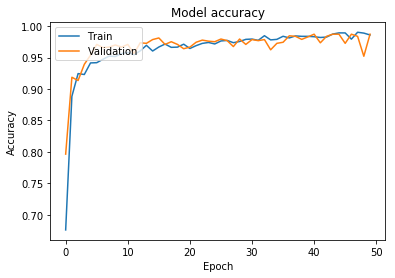

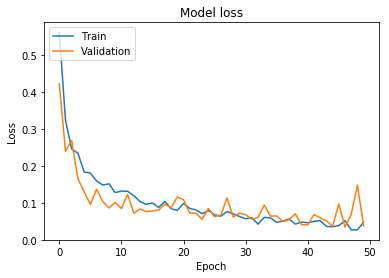

In [8]:
# Final accuracy and loss
print ("Train accuracy: %.3f" % (history.history['acc'][-1]))
print ("Train loss: %.3f" % (history.history['loss'][-1]),"\n")

print ("Validation accuracy: %.3f" % (history.history['val_acc'][-1]))
print ("Validation loss: %.3f" % (history.history['val_loss'][-1]))

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Matriz de confusão para o conjunto de validação ###
Found 1200 images belonging to 2 classes.
37/37 [==============================] - 57s 2s/step


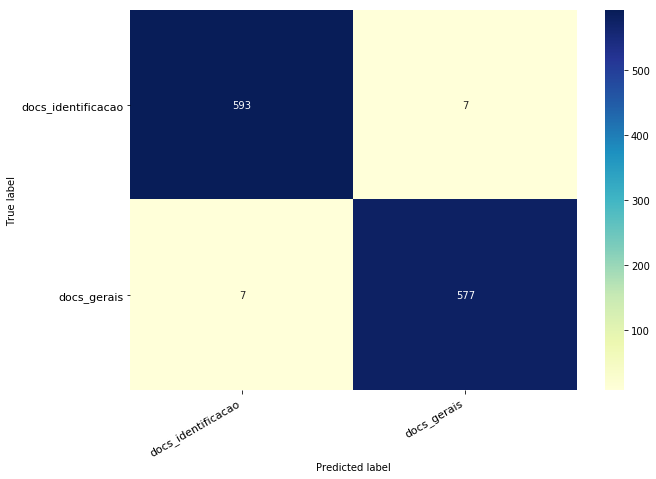

In [9]:
### Conjunto de Validação ###

print ("### Matriz de confusão para o conjunto de validação ###")

#Conjunto de validação
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_set = validation_datagen.flow_from_directory('classificador_B/validation/',
                                            target_size = (128, 128),
                                            color_mode="rgb",
                                            batch_size = batch, #alterado para 1
                                            class_mode = 'categorical',
                                            shuffle= False)


#Confution Matrix
Y_pred = classifier.predict_generator(validation_set, num_validation//batch, verbose=1)

test_preds = np.argmax(Y_pred, axis=-1)
l=test_preds.shape[0]
test_trues = validation_set.classes
cm =confusion_matrix(test_trues[:l], test_preds)

print_confusion_matrix(cm, ["docs_identificacao", "docs_gerais"], figsize = (10,7), fontsize=11)


### Matriz de confusão para o conjunto de teste ###
Found 600 images belonging to 2 classes.
600/600 [==============================] - 35s 59ms/step
Test accuracy: 0.977
Test loss: 0.073


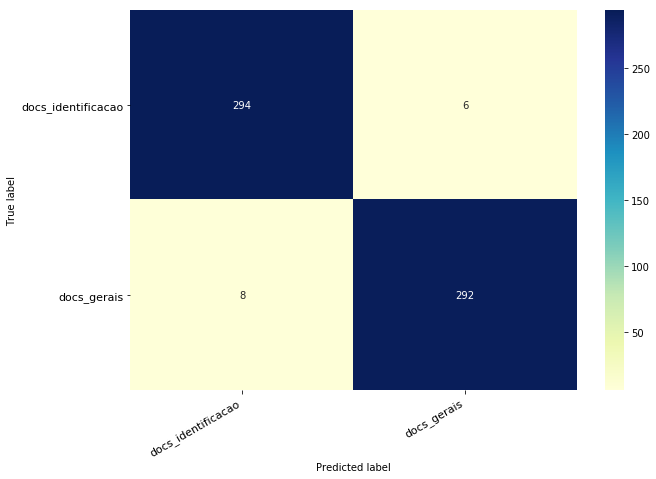

In [10]:
### Conjunto de Teste ###

print ("### Matriz de confusão para o conjunto de teste ###")

test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('classificador_B/test/',
                                            target_size = (128, 128),
                                            color_mode="rgb",
                                            batch_size = 1,
                                            class_mode = 'categorical',
                                            shuffle=False)
num_test = test_set.samples


#Confution Matrix
Y_pred = classifier.predict_generator(test_set, num_test, verbose=1)

test_preds = np.argmax(Y_pred, axis=-1)
l=test_preds.shape[0]
test_trues = test_set.classes
cm =confusion_matrix(test_trues[:l], test_preds)

print_confusion_matrix(cm, ["docs_identificacao", "docs_gerais"], figsize = (10,7), fontsize=11)

# Accuracy and Loss for the Test set
loss, acc = classifier.evaluate_generator(test_set, num_test, verbose=1)

# Final accuracy and loss
print ("Test accuracy: %.3f" % acc)
print ("Test loss: %.3f" % loss)
